In [86]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

# Import all the datasets and perform the preliminary inspection.

> *   Check for missing values and duplicates.
> *   Remove any anomalies found in the data.


In [87]:
# Load the datasets
user_df = pd.read_csv('user.csv')
tourism_df = pd.read_excel('tourism_with_id.xlsx')
tourism_rating_df = pd.read_csv('tourism_rating.csv')

In [88]:
tourism_df.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2


In [89]:
user_df.head(2)

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21


In [90]:
tourism_rating_df.head(2)

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2


In [91]:
tourism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [92]:
tourism_df.isna().sum()

Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
Unnamed: 11     437
Unnamed: 12       0
dtype: int64

In [93]:
tourism_df.columns

Index(['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price',
       'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Unnamed: 11',
       'Unnamed: 12'],
      dtype='object')

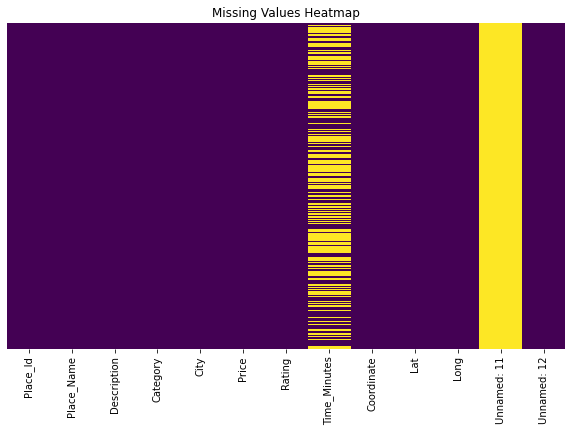

In [94]:
def visualize_missing_values(data):
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.isnull(), cbar=False, cmap="viridis", yticklabels=False)
    plt.title("Missing Values Heatmap")
    plt.show()

# Usage example
visualize_missing_values(tourism_df)


## Remove columns : 
> Unnamed: 11 : empty column

> Unnamed: 12  : contains just serial numbers

> time minutes : 47% of values are missing

> coordinate : contains latitude longitude info already presnt as separate columns

In [95]:
# Drop columns with anomalies
columns_to_drop = ['Unnamed: 11', 'Unnamed: 12', 'Time_Minutes', 'Coordinate']
tourism_df.drop(columns=columns_to_drop, inplace=True)

In [96]:
tourism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Place_Id     437 non-null    int64  
 1   Place_Name   437 non-null    object 
 2   Description  437 non-null    object 
 3   Category     437 non-null    object 
 4   City         437 non-null    object 
 5   Price        437 non-null    int64  
 6   Rating       437 non-null    float64
 7   Lat          437 non-null    float64
 8   Long         437 non-null    float64
dtypes: float64(3), int64(2), object(4)
memory usage: 30.9+ KB


In [97]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


In [98]:
tourism_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [99]:
# Ensure column consistency
tourism_df.columns = tourism_df.columns.str.strip()

# 2. To understand the tourism highlights better, we should explore the data in depth.
## a. Starting with exploring the user group used to get the tourism ratings. For example we may explore
> 1. The age distribution of users visiting the places and giving the ratings.


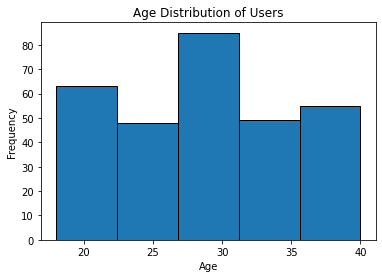

In [100]:
# 1. Exploring user demographics
def plot_histogram(data, column, bins=5, title="Histogram"):
    data[column].plot(kind='hist', bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(user_df, 'Age', title="Age Distribution of Users")


> 2. What are the places from where most of these users (tourists) are coming from?

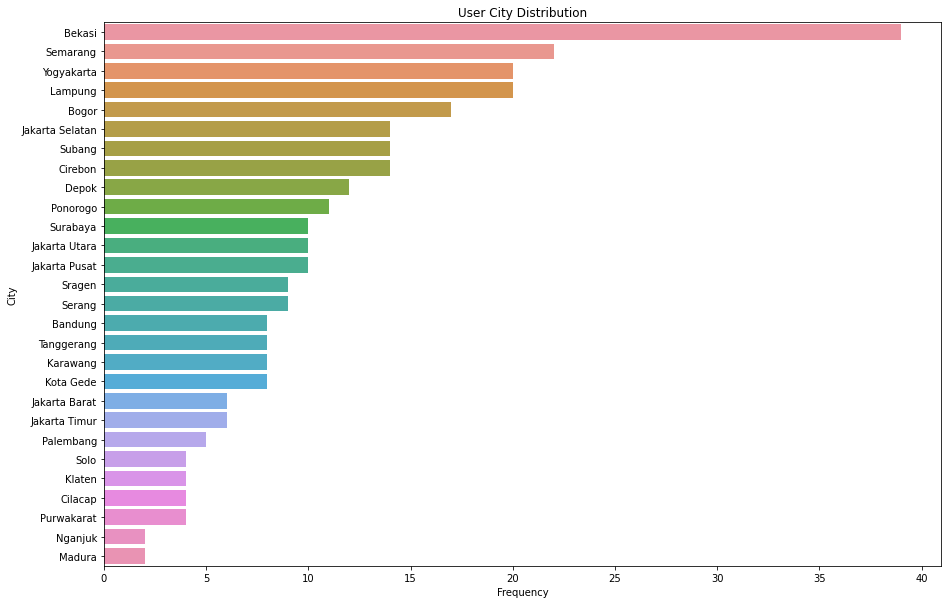

In [101]:
# User city distribution
user_df['city'] = user_df['Location'].apply(lambda x: x.split(",")[0])
plt.figure(figsize=(15, 10))
sns.countplot(y="city", data=user_df, order=user_df['city'].value_counts().index)
plt.title("User City Distribution")
plt.xlabel("Frequency")
plt.ylabel("City")
plt.show()


## Next, lets explore the locations and categories of tourist spots.



In [102]:
tourism_df.columns

Index(['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price',
       'Rating', 'Lat', 'Long'],
      dtype='object')


> 1. What are the different categories of tourist spots?

In [103]:
tourism_df.Category = tourism_df.Category.str.strip().str.capitalize()



> 2. What kind of tourism each city/location most famous or suitable for ?


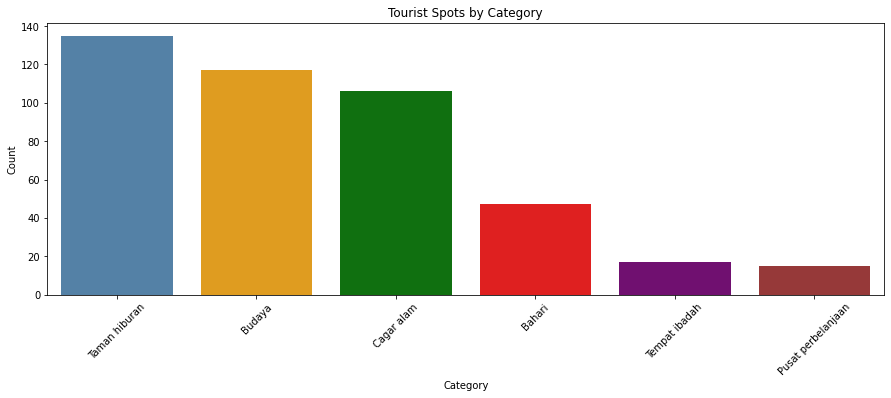

In [104]:
# Plot categories with consistent colors
category_colors = {
    'Taman hiburan': 'steelblue',
    'Budaya': 'orange',
    'Cagar alam': 'green',
    'Bahari': 'red',
    'Tempat ibadah': 'purple',
    'Pusat perbelanjaan': 'brown'
}  

category_counts = tourism_df['Category'].value_counts()

plt.figure(figsize=(15, 5))
sns.barplot(x=category_counts.index, y=category_counts.values,
            palette=[category_colors.get(cat, 'grey') for cat in category_counts.index])
plt.title("Tourist Spots by Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

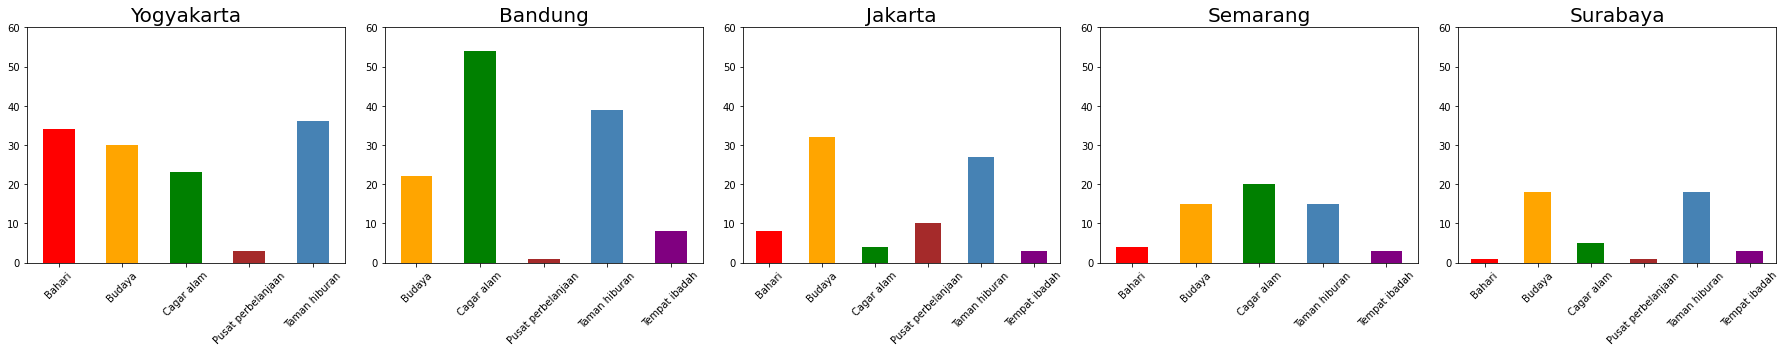

In [105]:
# Create subplots
f, ax = plt.subplots(1, 5, figsize=(25, 5))
i = 0

# Loop over each city and plot category counts with consistent colors
for c in tourism_df.City.value_counts().index[:5]:  # Adjust to display only top 5 cities
    temp = tourism_df[tourism_df.City == c]
    category_counts = temp.Category.value_counts().sort_index()
    
    # Plot with consistent colors for each category based on the `colors` dictionary
    category_counts.plot.bar(
        ax=ax[i],
        color=[category_colors.get(cat, 'grey') for cat in category_counts.index]  # Default to grey if category not in colors
    )
    ax[i].set_ylabel("")
    ax[i].set_ylim(0, 60)
    ax[i].set_title(c, size=20)
    ax[i].set_xticklabels(labels=category_counts.index, rotation=45)
    i += 1

plt.tight_layout()
plt.show()


### __3. Which city would be best for a nature enthusiast to visit?__

In [106]:
tourism_df.Category.unique()

array(['Budaya', 'Taman hiburan', 'Cagar alam', 'Bahari',
       'Pusat perbelanjaan', 'Tempat ibadah'], dtype=object)

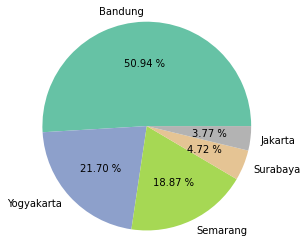

In [107]:
# Define the replace_terms function
def replace_terms(data, column, replacements):
    data[column] = data[column].replace(replacements)
    return data

# Replace "Nature preserve" with "Cagar alam" in the Category column
tourism_df = replace_terms(tourism_df, 'Category', {'Nature preserve': 'Cagar alam'})

# Now plot the pie chart using the updated category name
vc = tourism_df[tourism_df.Category == "Cagar alam"].City.value_counts()
vc.plot.pie(radius=1.2, cmap="Set2", autopct="%1.2f %%")
plt.ylabel("")
plt.show()

<AxesSubplot: >

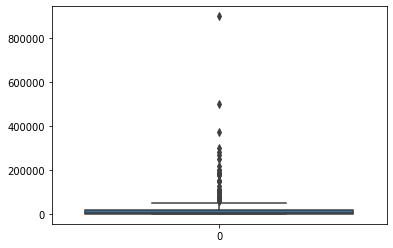

In [108]:
sns.boxplot(tourism_df.Price)


##  To better understand tourism we need to create a combined data with places and their ratings.

In [109]:
tourism_rating_df.head(2)

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2


In [110]:
tourism_df.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,-6.137645,106.817125


## Calculate weighted average ratings for each place

In [111]:
ratings = tourism_rating_df.groupby('Place_Id')[['Place_Ratings']].mean().round(2).reset_index()
ratings.head(2)

,Place_Id,Place_Ratings
0,1,3.72
1,2,2.84


In [112]:
place_ratings = pd.merge(tourism_df, ratings, on = 'Place_Id', how = "left")
place_ratings.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Lat,Long,Place_Ratings
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,-6.175392,106.827153,3.72
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,-6.137645,106.817125,2.84



## Use this data to figure out the spots that  are most loved by the tourists. 

In [113]:
place_ratings.sort_values("Place_Ratings",ascending = False)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Lat,Long,Place_Ratings
415,416,Keraton Surabaya,Kawasan yang berjuluk Kampung Keraton ini terd...,Budaya,Surabaya,0,4.4,-7.256755,112.794220,3.97
138,139,Puncak Gunung Api Purba - Nglanggeran,Gunung Nglanggeran adalah sebuah gunung di Dae...,Cagar alam,Yogyakarta,10000,4.7,-7.841253,110.543056,3.88
51,52,Kampung Cina,KAMPUNG China adalah hunian dan kawasan perdag...,Budaya,Jakarta,15000,4.5,-6.365136,106.761798,3.84
253,254,Teras Cikapundung BBWS,Teras Cikapundung Bandung sebelumnya merupakan...,Taman hiburan,Bandung,0,4.3,-6.884420,107.606834,3.79
321,322,Bukit Jamur,Bukit Jamur Ciwidey adalah satu dari sekian ba...,Cagar alam,Bandung,0,4.2,-7.195110,107.431281,3.77
...,...,...,...,...,...,...,...,...,...,...
72,73,Museum Perangko,Museum perangko dibangun dengan bentuk banguna...,Budaya,Jakarta,5000,4.4,-6.304184,106.901773,2.24
233,234,Amazing Art World,"Amazing Art World Bandung, sebuah objek wisata...",Budaya,Bandung,75000,4.5,-6.851659,107.595553,2.22
208,209,Pantai Sanglen,Pantai Sanglen. Lokasinya berada di Desa Kemad...,Bahari,Yogyakarta,10000,4.5,-8.136746,110.571636,2.21
103,104,Tebing Breksi,Tebing Breksi merupakan tempat wisata yang ber...,Budaya,Yogyakarta,20000,4.4,-7.781571,110.504583,2.17


## Also, which city has the most loved tourist spots.

__Solution:__ Picking up the places with average rating above 3.5 as most loved places and finding the cities where most of these highly rated spots are present

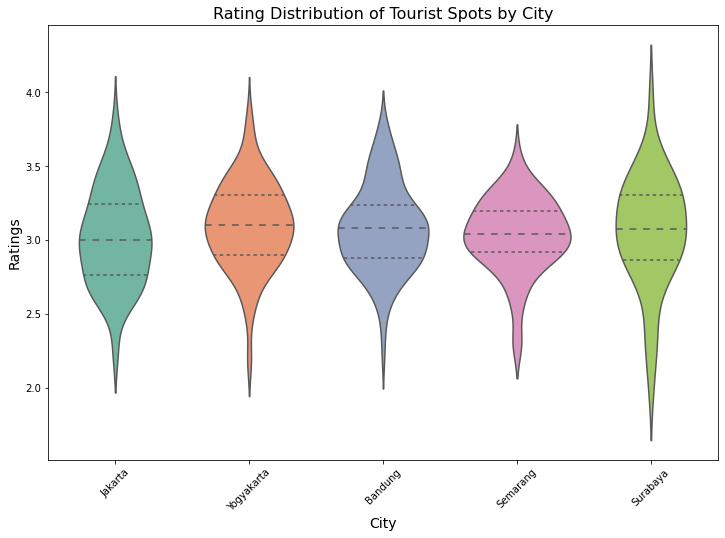

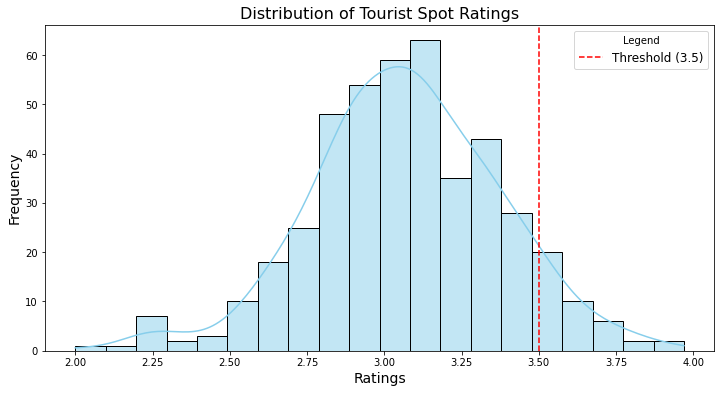

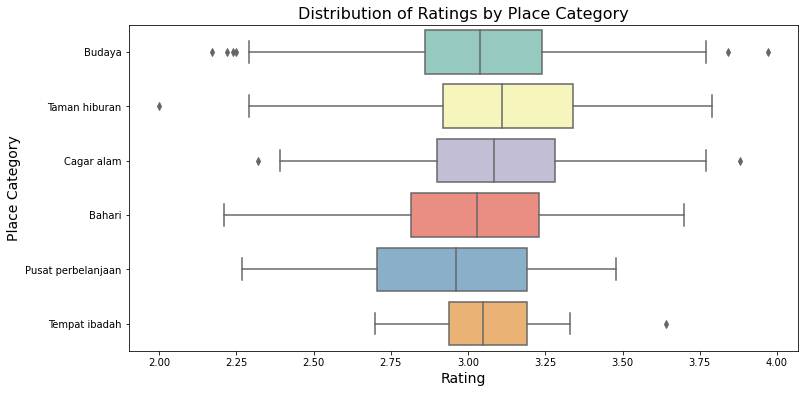

Percentage of places with ratings > 3.5: 6.86%
Percentage of places with ratings <= 3.5: 93.14%


In [114]:
# 1. City-wise Distribution (Violin Plot)
plt.figure(figsize=(12, 8))
sns.violinplot(x=place_ratings['City'], y=place_ratings['Place_Ratings'], inner='quartile', palette="Set2")
plt.title("Rating Distribution of Tourist Spots by City", fontsize=16)
plt.xlabel("City", fontsize=14)
plt.ylabel("Ratings", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# 2. Overall Distribution with Threshold (Histogram)
plt.figure(figsize=(12, 6))
sns.histplot(place_ratings['Place_Ratings'], bins=20, kde=True, color='skyblue')
plt.axvline(x=3.5, color='red', linestyle='--', label='Threshold (3.5)')
plt.title("Distribution of Tourist Spot Ratings", fontsize=16)
plt.xlabel("Ratings", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(title="Legend", fontsize=12)
plt.show()

# 3. Category-wise Distribution (Box Plot)
plt.figure(figsize=(12, 6))
sns.boxplot(data=place_ratings, x='Place_Ratings', y='Category', palette='Set3')
plt.title("Distribution of Ratings by Place Category", fontsize=16)
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Place Category", fontsize=14)
plt.show()

# Percentage Calculation for Threshold Context
above_threshold = (place_ratings['Place_Ratings'] > 3.5).sum()
below_threshold = (place_ratings['Place_Ratings'] <= 3.5).sum()
total = len(place_ratings)
print(f"Percentage of places with ratings > 3.5: {above_threshold / total * 100:.2f}%")
print(f"Percentage of places with ratings <= 3.5: {below_threshold / total * 100:.2f}%")


- Yogyakarta and Surabaya have a slightly higher spread of ratings, extending closer to 4.5, indicating some high-rated spots.
- Bandung has a more concentrated distribution around the median, suggesting that the ratings for tourist spots are relatively consistent in this city.

## Indonesia provides a wide range of tourist spots ranging from historical and cultural beauties to advanced amusement parks. What category of places are users liking the most amongst these ?


-- Again picking up the places with average rating above 3.5 and finding out the which are the most liked categories

-- Most people liking the amusement parks very closely followed by the nature preserve.

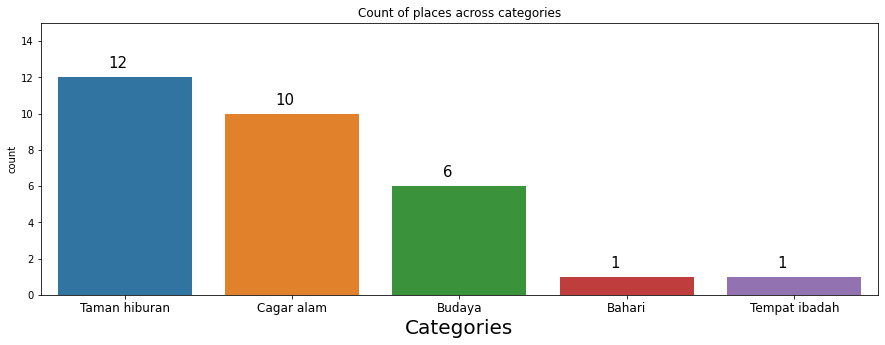

In [115]:
vc = place_ratings[place_ratings.Place_Ratings >3.5].Category.value_counts()
plt.figure(figsize = (15,5))
sns.countplot(x = "Category", data = place_ratings[place_ratings.Place_Ratings >3.5], order = vc.index)
i= 0
for idx in vc.index:
  plt.annotate(vc[idx], xy = (i-0.1, vc[idx]+0.5), size = 15)
  i += 1
plt.xlabel('Categories', size = 20)
plt.ylim(0, 15)
plt.xticks(size = 12)
plt.title("Count of places across categories")
plt.show()
plt.show()

# Build a Recommendation model for the tourists.

- Create a dataframe with information about these spots to include place id, user rating, name, description, category, location and price.


- Use the above data to develop a content based filtering model for recommendation. And use that to recommend other places to visit using the current tourist location(place name).



In [116]:
recom_data = tourism_rating_df.merge(tourism_df[["Place_Id", "Place_Name", "City"]], on = "Place_Id", how = "left")
recom_data.head(2)

,User_Id,Place_Id,Place_Ratings,Place_Name,City
0,1,179,3,Candi Ratu Boko,Yogyakarta
1,1,344,2,Pantai Marina,Semarang


In [117]:
ratings_data = recom_data.groupby(['User_Id', 'Place_Name'])['Place_Ratings'].mean().unstack()

In [118]:
ratings_data

Place_Name,Air Mancur Menari,Air Terjun Kali Pancur,Air Terjun Kedung Pedut,Air Terjun Semirang,Air Terjun Sri Gethuk,Alive Museum Ancol,Alun Alun Selatan Yogyakarta,Alun-Alun Kota Bandung,Alun-alun Utara Keraton Yogyakarta,Amazing Art World,...,Wisata Alam Wana Wisata Penggaron,Wisata Batu Kuda,Wisata Eling Bening,Wisata Kaliurang,Wisata Kampung Krisan Clapar,Wisata Kraton Jogja,Wisata Kuliner Pecenongan,Wisata Lereng Kelir,Wisata Mangrove Tapak,Wot Batu
User_Id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,NaN,3.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
297,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
# Normalize user-item matrix
data_norm = ratings_data.subtract(ratings_data.mean(axis=1), axis = 'rows')
data_norm.head()

Place_Name,Air Mancur Menari,Air Terjun Kali Pancur,Air Terjun Kedung Pedut,Air Terjun Semirang,Air Terjun Sri Gethuk,Alive Museum Ancol,Alun Alun Selatan Yogyakarta,Alun-Alun Kota Bandung,Alun-alun Utara Keraton Yogyakarta,Amazing Art World,...,Wisata Alam Wana Wisata Penggaron,Wisata Batu Kuda,Wisata Eling Bening,Wisata Kaliurang,Wisata Kampung Krisan Clapar,Wisata Kraton Jogja,Wisata Kuliner Pecenongan,Wisata Lereng Kelir,Wisata Mangrove Tapak,Wot Batu
User_Id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.166667,NaN,NaN,NaN,NaN,-1.166667,NaN,-0.166667
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.344828,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
# User similarity matrix using Pearson correlation
user_similarity = data_norm.T.corr()
user_similarity.head()

User_Id,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
User_Id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.981981,NaN,NaN,NaN,1.000000,-1.000000,0.188982,...,NaN,NaN,NaN,-0.192450,NaN,NaN,NaN,-1.000000,-0.379980,NaN
2,NaN,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,-1.0,-0.188982,NaN,-1.000000,-1.0,-0.5,-0.164771,-1.000000,0.577350,NaN
3,NaN,-1.0,1.0,NaN,NaN,NaN,NaN,1.000000,-0.654654,NaN,...,NaN,1.000000,NaN,-0.388889,-1.0,NaN,1.000000,1.000000,NaN,NaN
4,0.981981,NaN,NaN,1.000000,NaN,-9.819805e-01,0.333333,1.000000,-1.000000,NaN,...,-1.0,-1.000000,NaN,-1.000000,-1.0,1.0,-1.000000,NaN,0.944911,NaN
5,NaN,NaN,NaN,NaN,1.0,-5.551115e-17,NaN,0.191741,-1.000000,1.000000,...,1.0,NaN,-1.0,-0.320750,-1.0,NaN,NaN,0.760726,NaN,-1.0


In [121]:
# Apply SVD for matrix factorization on the normalized user-item matrix
svd = TruncatedSVD(n_components=20, random_state=42)
user_factors = svd.fit_transform(data_norm.fillna(0))  # Factor matrix for users
item_factors = svd.components_.T  # Factor matrix for items

# Calculate user similarity using the reduced dimensionality user factors
user_similarity_svd = cosine_similarity(user_factors)


In [122]:
# Pick a user ID
picked_userid = 1
# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)
# Take a look at the data
user_similarity.head()

User_Id,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
User_Id,,,,,,,,,,,,,,,,,,,,,
2,NaN,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,-1.0,-0.188982,NaN,-1.000000,-1.0,-0.5,-0.164771,-1.000000,0.577350,NaN
3,NaN,-1.0,1.0,NaN,NaN,NaN,NaN,1.000000,-0.654654,NaN,...,NaN,1.000000,NaN,-0.388889,-1.0,NaN,1.000000,1.000000,NaN,NaN
4,0.981981,NaN,NaN,1.000000,NaN,-9.819805e-01,0.333333,1.000000,-1.000000,NaN,...,-1.0,-1.000000,NaN,-1.000000,-1.0,1.0,-1.000000,NaN,0.944911,NaN
5,NaN,NaN,NaN,NaN,1.000000e+00,-5.551115e-17,NaN,0.191741,-1.000000,1.0,...,1.0,NaN,-1.0,-0.320750,-1.0,NaN,NaN,0.760726,NaN,-1.0
6,NaN,NaN,NaN,-0.981981,-5.551115e-17,1.000000e+00,0.000000,-1.000000,NaN,NaN,...,0.5,0.987829,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN


In [123]:
# Number of similar users
n = 10
# User similarity threshold
user_similarity_threshold = 0.3

# Get similarity scores for picked_userid, then filter out picked_userid from the results
similar_users = pd.Series(user_similarity_svd[picked_userid - 1])
similar_users.index = range(1, len(similar_users) + 1)  # Re-index to match user IDs starting from 1
similar_users = similar_users.drop(index=picked_userid).sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)


The similar users for user 1 are 57     0.563326
2      0.545286
72     0.487975
93     0.455908
89     0.447653
251    0.408578
254    0.384427
189    0.377853
224    0.367323
263    0.364892
dtype: float64


In [124]:
# Places that the target user has visited and rated
picked_userid_rated = data_norm[data_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_rated.T

User_Id,1
Place_Name,
Atlantis Water Adventure,1.586207
Candi Ratu Boko,-0.413793
Curug Anom,-0.413793
Curug Tilu Leuwi Opat,0.586207
De Mata Museum Jogja,-0.413793
Grand Maerakaca,0.586207
Gua Pawon,-1.413793
Kampung Wisata Sosro Menduran,0.586207
Margasatwa Muara Angke,0.586207


In [125]:
# Places that similar users visited and rated. 
similar_user_places = data_norm[data_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_places


Place_Name,Air Terjun Sri Gethuk,Alun-Alun Kota Bandung,Atlantis Land Surabaya,Balai Kota Surabaya,Bangsal Pagelaran,Bentara Budaya Yogyakarta (BBY),Benteng Pendem,Brown Canyon,Bukit Gantole Cililin,Bukit Jamur,...,Watu Lumbung,Wisata Alam Kalibiru,Wisata Alam Mangrove Angke,Wisata Alam Wana Wisata Penggaron,Wisata Eling Bening,Wisata Kampung Krisan Clapar,Wisata Kuliner Pecenongan,Wisata Lereng Kelir,Wisata Mangrove Tapak,Wot Batu
User_Id,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,0.833333,-1.166667,-1.166667,NaN,-1.166667,NaN,0.833333,...,NaN,NaN,NaN,NaN,-0.166667,NaN,NaN,-1.166667,NaN,-0.166667
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.632353,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,NaN,NaN,NaN,-1.857143,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,-0.942308,NaN,0.057692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.057692,-0.942308,NaN,NaN,NaN,NaN,NaN,NaN
93,1.783784,NaN,NaN,1.783784,NaN,NaN,-1.216216,NaN,0.783784,NaN,...,-0.216216,NaN,NaN,NaN,NaN,NaN,-1.216216,-2.216216,1.783784,NaN
189,NaN,0.636364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,NaN,NaN,-0.846154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.083333,NaN,NaN,1.916667,NaN


In [126]:
# Remove the places already visitied
similar_user_places.drop(picked_userid_rated.columns,axis=1, inplace=True, errors='ignore')
# Take a look at the data
similar_user_places

Place_Name,Air Terjun Sri Gethuk,Alun-Alun Kota Bandung,Atlantis Land Surabaya,Balai Kota Surabaya,Bangsal Pagelaran,Bentara Budaya Yogyakarta (BBY),Benteng Pendem,Brown Canyon,Bukit Gantole Cililin,Bukit Jamur,...,Watu Lumbung,Wisata Alam Kalibiru,Wisata Alam Mangrove Angke,Wisata Alam Wana Wisata Penggaron,Wisata Eling Bening,Wisata Kampung Krisan Clapar,Wisata Kuliner Pecenongan,Wisata Lereng Kelir,Wisata Mangrove Tapak,Wot Batu
User_Id,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,0.833333,-1.166667,-1.166667,NaN,-1.166667,NaN,0.833333,...,NaN,NaN,NaN,NaN,-0.166667,NaN,NaN,-1.166667,NaN,-0.166667
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.632353,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,NaN,NaN,NaN,-1.857143,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,-0.942308,NaN,0.057692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.057692,-0.942308,NaN,NaN,NaN,NaN,NaN,NaN
93,1.783784,NaN,NaN,1.783784,NaN,NaN,-1.216216,NaN,0.783784,NaN,...,-0.216216,NaN,NaN,NaN,NaN,NaN,-1.216216,-2.216216,1.783784,NaN
189,NaN,0.636364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,NaN,NaN,-0.846154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.083333,NaN,NaN,1.916667,NaN


In [127]:
# A dictionary to store item scores
item_score = {}
# Loop through items
for i in similar_user_places.columns:
  
  # Get the ratings for movie i
  place_rating = similar_user_places[i]
  
  # Create a variable to store the score
  total = 0
  
  # Create a variable to store the number of scores
  count = 0
  
  # Loop through similar users
  for u in similar_users.index:
    # If the place has rating
    if pd.isna(place_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the place rating
      score = similar_users[u] * place_rating[u]
      # Add the score to the total score for the place so far
      total += score
      # Add 1 to the count
      count +=1
  
  # Get the average score for the item
  item_score[i] = total / count


# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['place', 'place_score'])
    
# Sort the places by score
ranked_item_score = item_score.sort_values(by='place_score', ascending=False)

# Select top m places
m = 10
ranked_item_score.place.tolist()[:10]

['NuArt Sculpture Park',
 'Desa Wisata Lembah Kalipancur',
 'Kampung Tematik Jawi',
 'Upside Down World Bandung',
 'Jurang Tembelan Kanigoro',
 'Pantai Pulang Sawal',
 'Perpustakaan Nasional',
 'Kota Tua',
 'Pantai Pok Tunggal',
 'Mountain View Golf Club']